# BERT4Rec-based recommendation system

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertModel, BertConfig
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Ensure compatibility with Jupyter Notebook
%matplotlib inline

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
import os
from google.colab import drive
drive.mount('/content/drive')
folder_path='/content/drive/MyDrive/CS247/Final Project'
os.chdir(folder_path)
# Function to load the MovieLens dataset


Mounted at /content/drive


In [3]:
# Function to load the MovieLens dataset
def load_data(filepath="ml-1m/ratings.dat"):
    df = pd.read_csv(filepath, sep="::", engine="python",
                     names=["userId", "movieId", "rating", "timestamp"])
    df = df.sort_values(by=["userId", "timestamp"])
    df['timestamp_bucket'] = df.groupby('userId')['timestamp'].transform(lambda x: x - x.min()) # size -> 89247793

    # # Reduce precision by bucketing timestamps (divide by 100 )-> save memory
    df['timestamp_bucket'] = df['timestamp_bucket'] // 20 # size -> 8924780

    # # Apply logarithmic bucketing (base 2) -> save memory
    # df['timestamp_bucket'] = np.log1p(df['timestamp_bucket']).astype(int)

    # Add time stamp to movie dict
    # user_movie_dict = df.groupby("userId")["movieId"].apply(list).to_dict()
    user_movie_dict = df.groupby("userId").agg({
        "movieId": list,
        "timestamp_bucket": list
    }).to_dict(orient="index")

    return user_movie_dict

# Load dataset
user_movie_dict = load_data()
print(f"Loaded {len(user_movie_dict)} users' movie interaction sequences with timestamps")

# Print a sample of user-movie interactions for debugging
for user, data in list(user_movie_dict.items())[:3]:
    print(f"User {user}:")
    print(f"  Movies: {data['movieId'][:5]}")
    print(f"  Timestamps: {data['timestamp_bucket'][:5]}")
    print("-" * 50)
timestamp_bins = max(max(data['timestamp_bucket']) for data in user_movie_dict.values()) + 1
print(f"Reduced Timestamp Bins: {timestamp_bins}")

Loaded 6040 users' movie interaction sequences with timestamps
User 1:
  Movies: [3186, 1270, 1721, 1022, 2340]
  Timestamps: [0, 1, 1, 1, 4]
--------------------------------------------------
User 2:
  Movies: [1198, 1210, 1217, 2717, 1293]
  Timestamps: [0, 1, 1, 3, 6]
--------------------------------------------------
User 3:
  Movies: [593, 2858, 3534, 1968, 1431]
  Timestamps: [0, 1, 2, 2, 3]
--------------------------------------------------
Reduced Timestamp Bins: 4462390


In [4]:
# Function to split user interactions into train and test sets -> split the movies
def split_train_test(user_movie_dict, test_ratio=0.2, min_interactions=5):
    train_dict, test_dict = {}, {}
    for user, data in user_movie_dict.items():
        movies = data['movieId']
        timestamps = data['timestamp_bucket']
        if len(movies) >= min_interactions:
            split_idx = int(len(movies) * (1 - test_ratio))
            train_dict[user] = {
                "movieId": movies[:split_idx],
                "timestamp_bucket": timestamps[:split_idx]
            }
            test_dict[user] = {
                "movieId": movies[split_idx:],
                "timestamp_bucket": timestamps[split_idx:]
            }
        else:
            train_dict[user] = {
                "movieId": movies,
                "timestamp_bucket": timestamps
            }
    return train_dict, test_dict


# Apply train-test split with filtering
train_dict, test_dict = split_train_test(user_movie_dict, test_ratio=0.2, min_interactions=5)

# Print updated user counts
print(f"Train users: {len(train_dict)}, Test users: {len(test_dict)}")

Train users: 6040, Test users: 6040


In [5]:
# Define Dataset for Training
class MovieDataset(Dataset):
    def __init__(self, user_movie_dict, max_len=30):
        self.users = list(user_movie_dict.keys())
        self.movie_sequences = [user_movie_dict[user]['movieId'] for user in self.users]
        self.timestamp_sequences = [user_movie_dict[user]['timestamp_bucket'] for user in self.users]
        self.max_len = max_len

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
            movie_seq = self.movie_sequences[idx]
            timestamp_seq = self.timestamp_sequences[idx]
            # Truncate and pad sequences
            input_movies = movie_seq[:self.max_len] + [0] * (self.max_len - len(movie_seq))
            input_timestamps = timestamp_seq[:self.max_len] + [0] * (self.max_len - len(timestamp_seq))
            # Next-movie prediction target
            target_movies = input_movies[1:] + [0]
            # Attention mask (1 for real tokens, 0 for padding)
            attention_mask = [1 if movie != 0 else 0 for movie in input_movies]
            return (
                torch.tensor(input_movies, dtype=torch.long),
                torch.tensor(input_timestamps, dtype=torch.long),
                torch.tensor(target_movies, dtype=torch.long),
                torch.tensor(attention_mask, dtype=torch.long)
          )
# Create Train Dataset & DataLoader
train_dataset = MovieDataset(train_dict, max_len=30)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Create Test Dataset & DataLoader
test_dataset = MovieDataset(test_dict, max_len=30)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train Dataset: {len(train_dataset)}, Test Dataset: {len(test_dataset)}")

Train Dataset: 6040, Test Dataset: 6040


In [7]:
# Transformer-based BERT4Rec Model
class BERT4Rec(nn.Module):
    def __init__(self, vocab_size,timestamp_bins, hidden_size=256, num_layers=4, num_heads=4, max_len=30, dropout_rate=0.2):
        super(BERT4Rec, self).__init__()
        self.movie_embedding = nn.Embedding(vocab_size, hidden_size)
        self.timestamp_embedding = nn.Embedding(timestamp_bins, hidden_size)
        # Positional Embedding
        self.position_embedding = nn.Embedding(max_len, hidden_size)
        config = BertConfig(
            vocab_size=vocab_size,
            hidden_size=hidden_size,
            num_attention_heads=num_heads,
            num_hidden_layers=num_layers,
            max_position_embeddings=max_len,
        )
        self.layernorm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.bert = BertModel(config)
        self.output_layer = nn.Linear(hidden_size, vocab_size)  # Output layer to predict next movie ID

    def forward(self, input_ids, timestamps, attention_mask):
         # Causal Mask: Ensure each position can only attend to previous positions
        batch_size, seq_len = input_ids.shape
        causal_mask = torch.triu(torch.ones(seq_len, seq_len, dtype=torch.bool, device=input_ids.device), diagonal=1)

        movie_emb = self.movie_embedding(input_ids)
        timestamp_emb = self.timestamp_embedding(timestamps)
        position_ids = torch.arange(seq_len, dtype=torch.long, device=input_ids.device)
        position_emb = self.position_embedding(position_ids).unsqueeze(0).expand(batch_size, -1, -1)

        # Combine embeddings (Sum for simplicity)
        combined_emb = movie_emb + timestamp_emb + position_emb

        output = self.bert(
            inputs_embeds=combined_emb,
            attention_mask=attention_mask,
            encoder_attention_mask=~causal_mask  # PyTorch requires masked positions to be False
        ).last_hidden_state
        output = self.layernorm(output)
        output = self.dropout(output)
        return self.output_layer(output)

# Initialize Model
# vocab_size = max(max(seq) for seq in user_movie_dict.values()) + 1  # Get max movie ID as vocab size
vocab_size = max(max(data['movieId']) for data in user_movie_dict.values()) + 1
timestamp_bins = max(max(data['timestamp_bucket']) for data in user_movie_dict.values()) + 1

model = BERT4Rec(
    vocab_size=vocab_size,
    timestamp_bins=timestamp_bins,
    hidden_size=256,
    num_layers=4,
    num_heads=4,
    max_len=30
).to(device)
print(f"Initialized BERT4Rec model with vocab size {vocab_size} and timestamp bins {timestamp_bins}")

Initialized BERT4Rec model with vocab size 3953 and timestamp bins 4462390


In [12]:
loss_list = []
# Define Training Function
def train_model(model, dataloader, epochs=3, lr=0.0001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # criterion = nn.CrossEntropyLoss()
    criterion = nn.CrossEntropyLoss(ignore_index=0)
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        for inputs, timestamps, targets, attention_mask in dataloader:
            # Move data to the device
            inputs = inputs.to(device)
            timestamps = timestamps.to(device)
            targets = targets.to(device)
            attention_mask = attention_mask.to(device)

            optimizer.zero_grad()
            outputs = model(inputs, timestamps, attention_mask)
            loss = criterion(outputs.view(-1, outputs.shape[-1]), targets.view(-1))
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch + 1}, Train Loss: {avg_loss:.4f}")
        loss_list.append(avg_loss)

# Train on Train DataLoader
train_model(model, train_dataloader, epochs=100, lr= 0.0001)

Epoch 1, Train Loss: 0.2753
Epoch 2, Train Loss: 0.2229
Epoch 3, Train Loss: 0.1839
Epoch 4, Train Loss: 0.1522
Epoch 5, Train Loss: 0.1278
Epoch 6, Train Loss: 0.1075
Epoch 7, Train Loss: 0.0906
Epoch 8, Train Loss: 0.0778
Epoch 9, Train Loss: 0.0669
Epoch 10, Train Loss: 0.0582
Epoch 11, Train Loss: 0.0503
Epoch 12, Train Loss: 0.0434
Epoch 13, Train Loss: 0.0380
Epoch 14, Train Loss: 0.0336
Epoch 15, Train Loss: 0.0289
Epoch 16, Train Loss: 0.0258
Epoch 17, Train Loss: 0.0220
Epoch 18, Train Loss: 0.0203
Epoch 19, Train Loss: 0.0182
Epoch 20, Train Loss: 0.0161
Epoch 21, Train Loss: 0.0147
Epoch 22, Train Loss: 0.0132
Epoch 23, Train Loss: 0.0121
Epoch 24, Train Loss: 0.0109
Epoch 25, Train Loss: 0.0107
Epoch 26, Train Loss: 0.0094
Epoch 27, Train Loss: 0.0088
Epoch 28, Train Loss: 0.0080
Epoch 29, Train Loss: 0.0073
Epoch 30, Train Loss: 0.0068
Epoch 31, Train Loss: 0.0060
Epoch 32, Train Loss: 0.0060
Epoch 33, Train Loss: 0.0064
Epoch 34, Train Loss: 0.0051
Epoch 35, Train Loss: 0

In [13]:
def evaluate_model(model, dataloader, k=10):
    model.eval()
    total_loss = 0
    total_recall = 0
    total_ndcg = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for inputs, timestamps, targets, attention_mask in dataloader:
            inputs, timestamps, targets, attention_mask = inputs.to(device), timestamps.to(device), targets.to(device), attention_mask.to(device)

            outputs = model(inputs, timestamps, attention_mask)
            loss = criterion(outputs.view(-1, outputs.shape[-1]), targets.view(-1))
            total_loss += loss.item()

            _, top_k_predictions = torch.topk(outputs, k, dim=-1)
            recall = recall_at_k(top_k_predictions, targets, k)
            ndcg = ndcg_at_k(top_k_predictions, targets, k)

            total_recall += recall
            total_ndcg += ndcg

    avg_loss = total_loss / len(dataloader)
    avg_recall = total_recall / len(dataloader)
    avg_ndcg = total_ndcg / len(dataloader)

    print(f"Test Loss: {avg_loss:.4f}, Recall@{k}: {avg_recall:.4f}, NDCG@{k}: {avg_ndcg:.4f}")
    return avg_loss, avg_recall, avg_ndcg

# Compute Recall@K
def recall_at_k(top_k_predictions, targets, k):
    hits = (top_k_predictions == targets.unsqueeze(-1)).float()  # Check if target is in top K
    recall = hits.sum(dim=-1).mean().item()  # Compute recall
    return recall

# Compute NDCG@K
def ndcg_at_k(top_k_predictions, targets, k):
    hits = (top_k_predictions == targets.unsqueeze(-1)).float()
    log_positions = 1 / torch.log2(torch.arange(2, k + 2, device=targets.device).float())  # Discount factor
    dcg = (hits * log_positions).sum(dim=-1).mean().item()
    return dcg

In [14]:
# Evaluate on Test DataLoader
test_loss, recall_k, ndcg_k = evaluate_model(model, test_dataloader, k=10)

Test Loss: 9.1500, Recall@10: 0.6024, NDCG@10: 0.6001


In [15]:
loss_history_baseline = [
    1.0829, 0.8475, 0.8103, 0.7828, 0.7473, 0.6993, 0.6543, 0.6029, 0.5485, 0.4827,
    0.4010, 0.3439, 0.3007, 0.2667, 0.2386, 0.2134, 0.1932, 0.1756, 0.1609, 0.1475,
    0.1365, 0.1262, 0.1167, 0.1083, 0.1014, 0.0954, 0.0891, 0.0839, 0.0794, 0.0754,
    0.0715, 0.0682, 0.0651, 0.0623, 0.0594, 0.0571, 0.0551, 0.0528, 0.0515, 0.0499,
    0.0482, 0.0472, 0.0458, 0.0445, 0.0435, 0.0422, 0.0416, 0.0408, 0.0399, 0.0394,
    0.0387, 0.0382, 0.0374, 0.0370, 0.0364, 0.0362, 0.0358, 0.0350, 0.0348, 0.0344,
    0.0345, 0.0338, 0.0335, 0.0333, 0.0331, 0.0329, 0.0325, 0.0323, 0.0319, 0.0321,
    0.0319, 0.0316, 0.0317, 0.0316, 0.0314, 0.0312, 0.0310, 0.0309, 0.0307, 0.0306,
    0.0305, 0.0307, 0.0304, 0.0303, 0.0302, 0.0301, 0.0300, 0.0300, 0.0299, 0.0299,
    0.0298, 0.0299, 0.0299, 0.0295, 0.0296, 0.0297, 0.0293, 0.0293, 0.0293, 0.0291
]
loss_history_time=loss_list
losses_dict = {
    "BERT4Rec": loss_history_baseline,
    "BERT4Rec_time": loss_history_time,
}



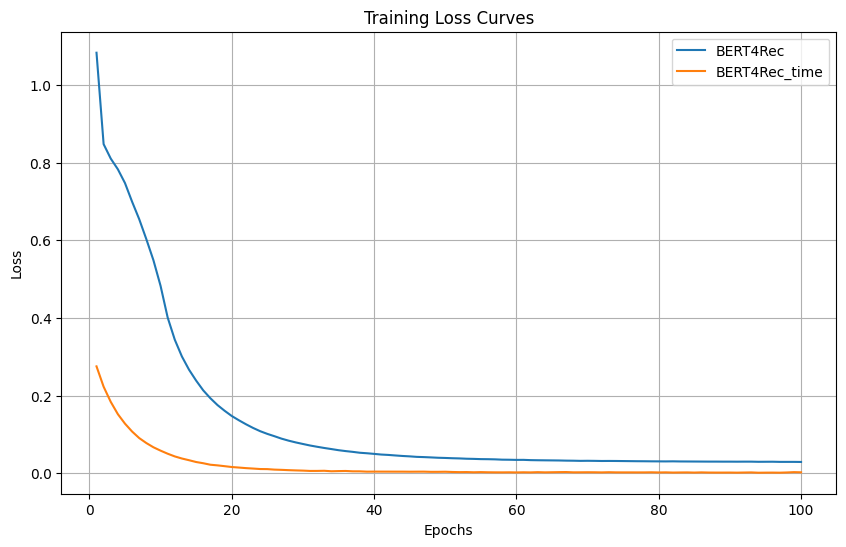

In [17]:
import matplotlib.pyplot as plt

def plot_loss_curves(losses_dict):
    """
    Plots loss curves for multiple models.

    Args:
        losses_dict (dict): Dictionary containing model names as keys and lists of loss values as values.
    """
    plt.figure(figsize=(10, 6))

    for model_name, losses in losses_dict.items():
        plt.plot(range(1, len(losses) + 1), losses, label=model_name)

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss Curves")
    plt.legend()
    plt.grid(True)
    plt.show()
plot_loss_curves(losses_dict)